## Model building and Hyperparameter tuning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, roc_curve)


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Define Seed value

In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Load the data

Download the dataset from here: [Early Stage Diabetes Risk Prediction
](https://github.com/lucifertrj/100DaysOfML/tree/main/data/diabetes_classification)

In [4]:
df = pd.read_csv('/content/diabetes_data.csv')

<Axes: >

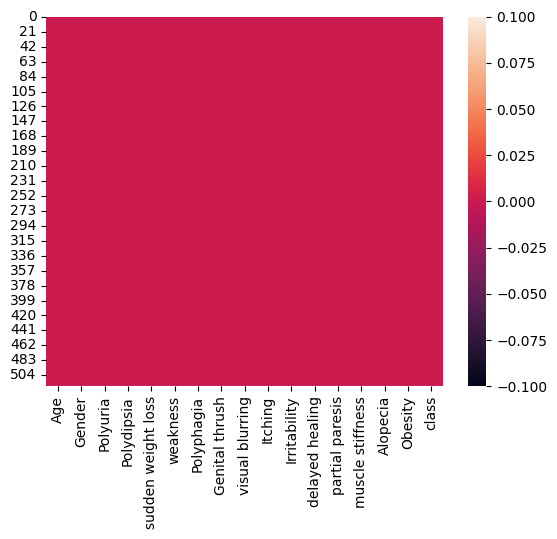

In [5]:
sns.heatmap(df.isnull())

In [6]:
df.sample(10)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
275,72,Male,Yes,No,No,No,Yes,No,Yes,Yes,No,Yes,Yes,Yes,Yes,No,Negative
93,40,Female,Yes,Yes,No,Yes,Yes,No,No,Yes,No,No,Yes,No,No,No,Positive
6,57,Male,Yes,Yes,No,Yes,Yes,Yes,No,No,No,Yes,Yes,No,No,No,Positive
167,41,Male,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,No,Yes,Positive
90,45,Female,No,No,No,No,Yes,No,Yes,Yes,No,No,Yes,No,No,No,Positive
513,62,Female,Yes,Yes,Yes,Yes,No,No,Yes,No,No,No,Yes,No,No,Yes,Positive
362,28,Female,No,No,No,No,No,No,Yes,No,No,No,Yes,Yes,No,No,Positive
228,45,Male,No,No,No,Yes,No,No,No,Yes,Yes,Yes,Yes,No,No,No,Negative
192,64,Male,No,Yes,No,No,No,No,No,No,Yes,Yes,No,No,No,No,Positive
482,42,Male,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,Negative


In [7]:
df.shape

(520, 17)

## Feature Transformation- Convert categorical feature to numeric value

In [8]:
le = LabelEncoder()

In [9]:
df['class']

,class
0,Positive
1,Positive
2,Positive
3,Positive
4,Positive
...,...
515,Positive
516,Positive
517,Positive
518,Negative


In [10]:
categorical_columns = df.select_dtypes(include=['object']).columns

In [11]:
categorical_columns

Index(['Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness',
       'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching',
       'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity', 'class'],
      dtype='object')

In [12]:
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

## Split your data

In [13]:
X = df.drop('class', axis=1)
y = df['class']

In [14]:
X.shape

(520, 16)

In [15]:
y

,class
0,1
1,1
2,1
3,1
4,1
...,...
515,1
516,1
517,1
518,0


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

In [28]:
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

Training set shape: (416, 16)
Testing set shape: (104, 16)
Training target shape: (416,)
Testing target shape: (104,)


## Model Building - Define Ensemble and Gradient boosting models

In [29]:
models = {
    'RandomForest': RandomForestClassifier(random_state=RANDOM_STATE),
    'AdaBoost': AdaBoostClassifier(random_state=RANDOM_STATE),
    'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)
}

#RandomForest(n_estimators = 11)

In [30]:
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    },
    'AdaBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 1.0, 1.5],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.1, 1.0, 1.5],
        'subsample': [0.3, 0.5, 1.0],
        'colsample_bytree': [0.5, 0.7, 1.0],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [1, 1.5, 2]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15, -1],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'num_leaves': [31, 50, 70, 100],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0, 0.1, 0.5]
    }
}

In [31]:
cv_folds = 5
n_iter = 50

In [32]:
best_models = {}

## Hyperparameter Tuning

In [35]:
for model_name, model in models.items():
    print(f"\nTuning {model_name}...")

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[model_name],
        n_iter=n_iter,
        cv=cv_folds,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )

    random_search.fit(X_train, y_train)

    best_models[model_name] = random_search.best_estimator_

    print(f"Best parameters for {model_name}:")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"Best CV score: {random_search.best_score_:.4f}")


Tuning RandomForest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for RandomForest:
  n_estimators: 200
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: log2
  max_depth: None
  bootstrap: True
Best CV score: 0.9979

Tuning AdaBoost...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for AdaBoost:
  n_estimators: 300
  learning_rate: 1.5
  algorithm: SAMME
Best CV score: 0.9701

Tuning XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for XGBoost:
  subsample: 1.0
  reg_lambda: 1.5
  reg_alpha: 0.1
  n_estimators: 200
  max_depth: 5
  learning_rate: 1.0
  gamma: 0
  colsample_bytree: 0.7
Best CV score: 0.9923

Tuning LightGBM...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for LightGBM:
  subsample: 1.0
  reg_lambda: 0
  reg_alpha: 0
  num_leaves: 100
  n_estimators: 200
  max_depth: -1
  learning_rate: 0.3
  colsample_bytree: 0.8
Best CV 

In [36]:
best_models.items()

dict_items([('RandomForest', RandomForestClassifier(max_features='log2', n_estimators=200, random_state=42)), ('AdaBoost', AdaBoostClassifier(algorithm='SAMME', learning_rate=1.5, n_estimators=300,
                   random_state=42)), ('XGBoost', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=1.0, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...))

## Training and Prediction of the model with best params


Evaluating RandomForest
Accuracy: 0.9904
Precision: 1.0000
Recall: 0.9844
F1 Score: 0.9921
ROC AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        40
           1       1.00      0.98      0.99        64

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104


Evaluating AdaBoost
Accuracy: 0.9615
Precision: 1.0000
Recall: 0.9375
F1 Score: 0.9677
ROC AUC: 0.9840

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        40
           1       1.00      0.94      0.97        64

    accuracy                           0.96       104
   macro avg       0.95      0.97      0.96       104
weighted avg       0.97      0.96      0.96       104


Evaluating XGBoost
Accuracy: 0.9808
Precision: 1.0000
Recall: 0.9688
F1 Score: 0.9841

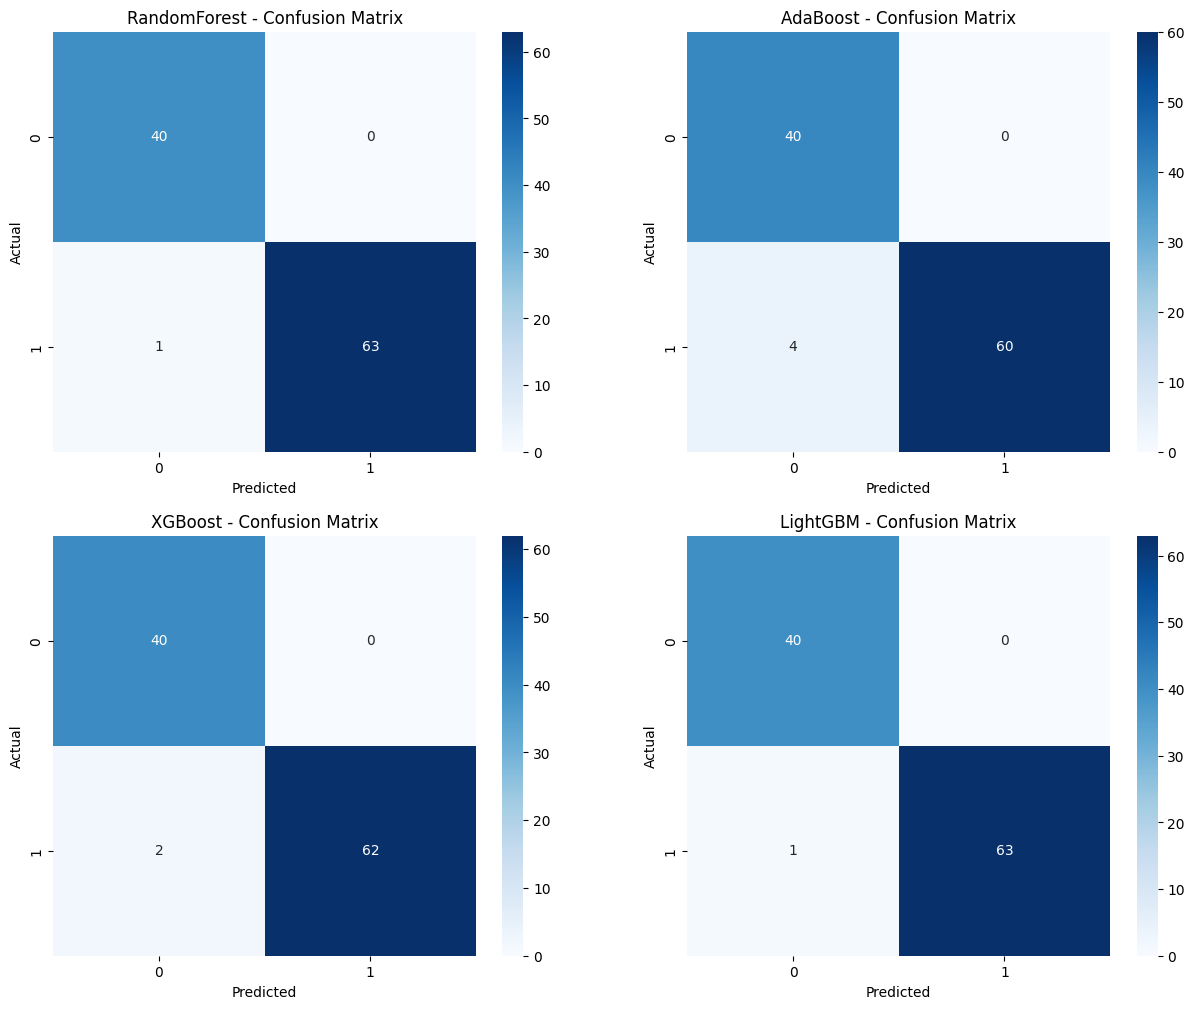

In [37]:
results = {}

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, (model_name, model) in enumerate(best_models.items()):
    print(f"\n{'='*50}")
    print(f"Evaluating {model_name}")
    print(f"{'='*50}")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results[model_name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{model_name} - Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.show()

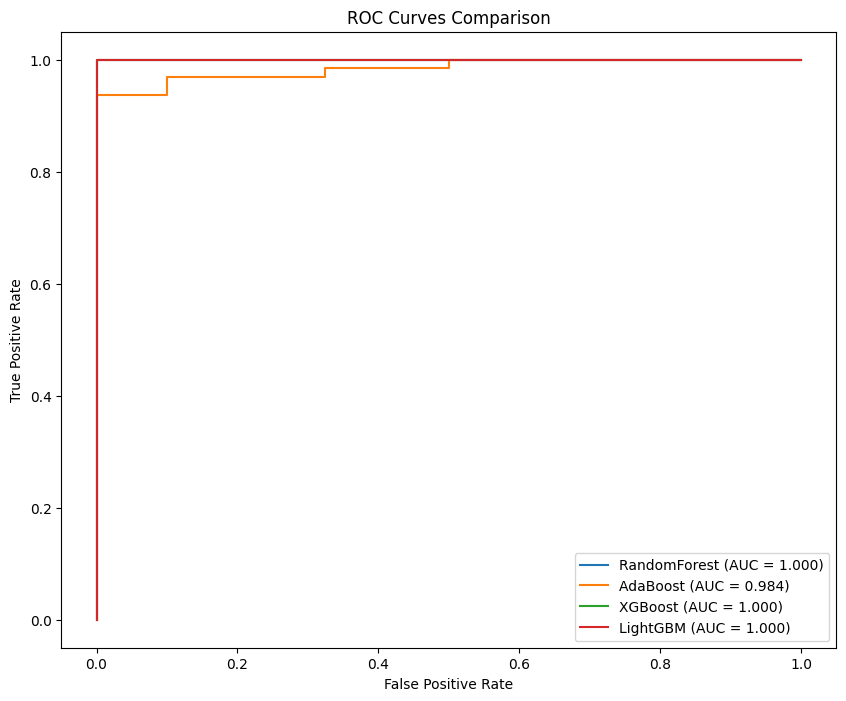

In [38]:
plt.figure(figsize=(10, 8))

for model_name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    auc_score = result['roc_auc']
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")